# MedNER
---  
  
Medikuntzako NER sistema gainbegiratu bat egingo da.

Horretarako, lehenik eta behin beharrezko liburutegiak inportatuko dira. Erabiliko da the Hugging Face Transformers liburutegia zeinak diseinatuta dagoen aurre-entrenatutako Transformer modeloak, BERT adibidez, erabiltzeko. Instalatzeko:


In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 22.9 MB/s 
     |████████████████████████████████| 7.6 MB 54.7 MB/s 
     |████████████████████████████████| 182 kB 67.6 MB/s 


Gainerako liburutegiak inportatuko dira:

In [2]:
from transformers import BertModel, BertTokenizer, BertTokenizerFast, BertForTokenClassification
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import random
import time
import spacy
import os

Konprobatuko da notebook-a GPUan exekutatzen dagoela ("Running on cuda" inprimatu beharko luke).

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on {}".format(device))

Running on cuda


Datuak dituen direktoria erabiliko da:

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/universidad/4.CURSO/HP/PROIEKTUA/data/"

Mounted at /content/drive
/content/drive/MyDrive/universidad/4.CURSO/HP/PROIEKTUA/data


## Datuak irakurri eta *train*, *dev* eta *test* partizioak egin

Anotatutako corpus guztia *corpus_pubtator.txt* fitxategian dago.  Datu hauek PubTator formatuan daude. Zehazki kasu bakoitza honela dago errepresentatuta:
  
```
PMID | t | Title text  
PMID | a | Abstract text    
PMID TAB StartIndex TAB EndIndex TAB MentionTextSegment TAB SemanticTypeID TAB EntityID
...
```

Lehenengo bi lerroek izenburuko eta laburpeneko testuak aurkezten dituzte (lerro-jauzirik eta tabulaziorik gabe testuan). Hurrengo lerroek aipamenak aurkezten dituzte, lerro bakoitzeko bana. *StartIndex* eta *EndIndex* dokumentuaren testuan 0an oinarritutako karaktereen aurkibideak dira, Izenburua eta Laburpena kateatuz eraikiak, SPACE karaktere batez bereiziak. *MentionTextSegment* karaktere-posizio horien arteko benetako aipamena da. *EntityID* UMLS entitatearen id da (kontzeptua), eta *SemanticTypeID* entitatea UMLSen lotuta dagoen mota semantikoaren id da. UMLS entitate mota semantiko bati baino gehiagori lotuta badago, eremu honek komen arabera bereizitako zerrenda bat du ID mota guztiekin. 2017-AA bertsio aktiboan ez dauden UMLS kontzeptu guztiak *UnknownType* mota semantiko bereziari lotuta daude.  

Jarraian adibide bat azaltzen da:
```
25763772|t|DCTN4 as a modifier of chronic Pseudomonas aeruginosa infection in cystic fibrosis
25763772|a|Pseudomonas aeruginosa (Pa) infection in cystic fibrosis (CF) patients is associated with worse long-term pulmonary disease and shorter survival, and chronic Pa infection (CPA) is associated with reduced lung function, faster rate of lung decline, increased rates of exacerbations and shorter survival. By using exome sequencing and extreme phenotype design, it was recently shown that isoforms of dynactin 4 (DCTN4) may influence Pa infection in CF, leading to worse respiratory disease. The purpose of this study was to investigate the role of DCTN4 missense variants on Pa infection incidence, age at first Pa infection and chronic Pa infection incidence in a cohort of adult CF patients from a single centre. Polymerase chain reaction and direct sequencing were used to screen DNA samples for DCTN4 variants. A total of 121 adult CF patients from the Cochin Hospital CF centre have been included, all of them carrying two CFTR defects: 103 developed at least 1 pulmonary infection with Pa, and 68 patients of them had CPA. DCTN4 variants were identified in 24% (29/121) CF patients with Pa infection and in only 17% (3/18) CF patients with no Pa infection. Of the patients with CPA, 29% (20/68) had DCTN4 missense variants vs 23% (8/35) in patients without CPA. Interestingly, p.Tyr263Cys tend to be more frequently observed in CF patients with CPA than in patients without CPA (4/68 vs 0/35), and DCTN4 missense variants tend to be more frequent in male CF patients with CPA bearing two class II mutations than in male CF patients without CPA bearing two class II mutations (P = 0.06). Our observations reinforce that DCTN4 missense variants, especially p.Tyr263Cys, may be involved in the pathogenesis of CPA in male CF.
25763772        0       5       DCTN4   T116,T123    C4308010
25763772        23      63      chronic Pseudomonas aeruginosa infection        T047    C0854135
25763772        67      82      cystic fibrosis T047    C0010674
25763772        83      120     Pseudomonas aeruginosa (Pa) infection   T047    C0854135
...
```

Bestalde, *train*, *dev* eta *test* partizioak *corpus_pubtator_pmids_trng.txt, corpus_pubtator_pmids_dev.txt, corpus_pubtator_pmids_test.txt* fitxategietan daude.  Hauek dokumentuaren  %60, %20, %20-ko ausazko partizioak dituzte, hurrenez hurren. Bakoitzean agertzen dira PMID kodeak zehaztuz bakoitzean dauden kasue kodeak.  

Beraz, partizioak egingo dira dokumentu bana izateko *train*, *dev* eta *test* kasuetarako. Horretarako:
1. Sortuko da fitxategi bana *train*, *dev* eta *test*-eko kasuak gordetzeko.
2. Irakurriko dira *corpus_pubtator_pmids_trng.txt, corpus_pubtator_pmids_dev.txt, corpus_pubtator_pmids_test.txt* fitxategiak. Irakurtzen den kode bakoitzeko *corpus_pubtator.txt* fitxategian  dagoen kasu hori hartuko da eta dagokion fitxategian (*train*, *dev* edo *test*) kopiatuko da.

### Aldagai orokorrak definitu direktorioak gordetzeko

In [5]:
data_directory = "corpus_pubtator.txt"

train_directory = "corpus_pubtator_pmids_trng.txt"
dev_directory = "corpus_pubtator_pmids_dev.txt"
test_directory = "corpus_pubtator_pmids_test.txt"

train_def_directory = "corpus_pubtator_train.txt"
dev_def_directory = "corpus_pubtator_dev.txt"
test_def_directory = "corpus_pubtator_test.txt"

### Fitxategiak sortu

In [6]:
def createFile(path):
    if not os.path.exists(path):
        os.makedirs(os.path.dirname(path), exist_ok=True)

def createDirectory(path):
    if not os.path.exists(path):
        os.mkdir(path)

createFile("./" + train_def_directory)
createFile("./" + dev_def_directory)
createFile("./" + test_def_directory)

### Fitxategiak idatzi

In [7]:
def idatzi_kasua(write_directory, line):
  with open(write_directory, "a") as f:
    f.write(line)

### Fitxategiak irakurri

In [8]:
def aurkitu_kasua(data_directory,write_directory, code):
  aurkitu = False
  with open(data_directory) as file:
        for line in file:
          if  "|" in line:
            lines = line.split("|")
          else:
            lines = line.split("\t")
            
          if lines[0] == code:
            aurkitu = True
            idatzi_kasua(write_directory, line)
          elif aurkitu:
            break

def read_makePartitions_txt(filename, write_directory):
    
    """ Read input one by line """
    with open(filename) as file:
        for line in file:
            aurkitu_kasua(data_directory, write_directory, line.strip())

In [ ]:
read_makePartitions_txt(train_directory, train_def_directory)
read_makePartitions_txt(dev_directory, dev_def_directory)
read_makePartitions_txt(test_directory, test_def_directory)

## Z1
MedMentions corpusa erabiliz NER sistema orokor bat
entrenatu, termino bat UMLSkoa den, hau da, osasunarekin zerikusia ote duen
jakiteko. Hau da, terminoak identifikatu, klase bakarra irteeran duzularik
(Medikuntzkoa edo MED).  

[DCTN4] as a modifier of [chronic Pseudomonas aeruginosa infection] in
[cystic fibrosis]

### BIO etiketatzea
Z1 betetzeko, partizioak eginda daudela hauetan dauden kasuak MedMentions-eko formatutik BIO etiketatzera egokituko dira. Aurrerago erabiliko diren ereduek formatu hau eskatzen dutelako.     


Etiketa bakarra egongo da, MED dena. Beraz, tokena entitate baten hasiera baldin bada B-MED etiketa jasoko du. I-MED izango du aldiz, entitatearen barruan baldin badago eta 0 ez bada entitate bat. Jarraian adibide bat aurkezten da:

```
[DCTN4] as a modifier of [chronic Pseudomonas aeruginosa infection] in [cystic fibrosis]

B-MED O O O O B-MED I-MED I-MED I-MED O B-MED I-MED
```

Lehenik eta behin fitxategi berriak sortuko dira *train*, *dev* eta *test* partizio bakoitzeko kasuak BIO etiketatzean gordetzeko.

In [9]:
#Aldagai orokorrak
train_BIO_directory_Z1 = "corpus_BIO_train_Z1.txt"
dev_BIO_directory_Z1 = "corpus_BIO_dev_Z1.txt"
test_BIO_directory_Z1 = "corpus_BIO_test_Z1.txt"

#sortu fitxategiak
createFile("./" + train_BIO_directory_Z1)
createFile("./" + dev_BIO_directory_Z1)
createFile("./" + test_BIO_directory_Z1)

Orain aurretik sortu diren fitxategiak (corpus_pubtator_train.txt, corpus_pubtator_test.txt eta corpus_pubtator_dev.txt) irakurri dira eta etiketatuko dira. Horretarako kasu bakoitzeko lehenengo bi lerroak irakurriko dira izenburua eta deskripzioa direnak, hain zuzen ere. Hauek etiketatuko dira O jarriz baldin eta hurrengo lerroetan ez badaude. Izan ere, lerro bana dago entitate bakoitzeko. Hasieran token guztiak 0 moduan etiketatuko dira eta gero, B-MED jarriko da baldin eta entitate baten hasiera bada eta I-MED entitate baten parte bada. Horretarako, hurrengo lerroak begiratuko dira eta aztertuko da *StartIndex*  eta *EndIndex* jakiteko zeintzuk diren entitateak.

Bestalde, *SpaCy*-ko tokenizatzailea erabiliko da titulua eta abstracta tokenizatzeko. Gainera, *MentionTextSegment* hainbat hitzez osatuta egon daitekenez baita erabiliko da hau tokenizatzeko.

SpaCy-ko inportak egingo eta tokenizatzailea definituko da:

In [10]:
# spaCy-ko lematizatzailea behar dugu baina gainerakoa kenduko dugu analisi-katetik
nlp = spacy.load('en_core_web_sm', disable=['tagger,ner,parser'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('ner')
nlp.remove_pipe('parser');

def tokenize(text):
  new_text = ""
  for t in text:
    if t == " ":
      new_text += "  "
    else:
      new_text += t

  spacy_tokens=[]
  spacy_tokens.extend([token.text for token in nlp(new_text)])
  return spacy_tokens


Hurrengo funtzioek fitxategi bakoitza irakurri eta BIO moduan etiketatu egiten dute klase bat daukagula bakarrik. Horretarako hainbat gauza kontutan hartzen dira:

*   Token bat bi aldiz etiketatu egon daiteke modu desberdinetan. Adibidez, olive orchards agertzen da kasu bateko abstract-ean. Kasu horretan, olive  eta olive orchards daude entitate moduan etiketatuta. Beraz, biak sartu behar dira. Kasu honetan, eskatzen du olive orchards entitatea sortzea eta sartzea, olive  entitatearen ondoren. 
* Aurrekoaren kontrakoa. Entitate bat hainbat tokenez osatuta dagoenean batzuetan horietako token bat baita dago etiketatuta entitate indibidual moduan. Adibidez, melanoma  tumors agertzen da kasu bateko abstract-ean. Kasu horretan, melanoma tumors  eta tumors daude entitate moduan etiketatuta. Beraz, biak sartu behar dira. Kasu honetan, eskatzen du tumors entitatea sortzea eta  sartzea, melanoma tumors entitatearen ondoren. 




In [11]:
def idatzi_entitateak(entitate_guztiak, write_directory):
  for entitatea in entitate_guztiak:
    if entitatea[0] != " ":
      text = entitatea[0] + "\t" + entitatea[3] + "\n"
      idatzi_kasua(write_directory, text)
  saltoa = "      \n" #lerro saltoa
  idatzi_kasua(write_directory, saltoa)


In [12]:
def readBIO_Z1_txt(filename, write_directory):
    
    """ Read input one by line """
    with open(filename) as file:
        lines = "" #it  will contain the tittle and abstract
        entitate_guztiak = []
        cont = 0
        cont_len = 0
        for line in file:
          if  "|" in line:
            if cont % 2 == 0 and cont != 0:
              #idatzi
              idatzi_entitateak(entitate_guztiak, write_directory)
              entitate_guztiak = []
              lines = ""           
              cont_len = 0   
            cont += 1
            text_ta = (line.split("|")[2]).split("\n")[0]
            tokenizatu_text_ta = tokenize(text_ta+ " ")
            for t in tokenizatu_text_ta:
              entitate_guztiak.append([t,cont_len , cont_len+len(t) ,"O"])
              cont_len += len(t)
            lines += text_ta + " "
          else:
            desk = line.split("\t")
            index_start = int(desk[1])
            index_end = int(desk[2])
            entitate = lines[index_start:index_end]
            entitate_tokenizatu = tokenize(entitate)
            first = True
            for ent in entitate_tokenizatu:
              if first:
                if ent != " ":
                  try:
                    index = entitate_guztiak.index([ent,index_start, index_start + len(ent), "O"])
                    entitate_guztiak[index] = [ent,index_start, index_start + len(ent), "B-MED"]
                    index_start += len(ent)
                    first = False
                  except:
                    index += 1
                    entitate_guztiak.insert(index, [ent, len(entitate_guztiak[index-1][0]), len(entitate_guztiak[index-1][0])+len(ent), "B-MED"])
                    index_start += len(ent)
                    first = False
                else:
                  index_start += 1
              elif ent != " ":
                try:
                  index = entitate_guztiak.index([ent,index_start, index_start +len(ent), "O"])
                  entitate_guztiak[index] = [ent,index_start, index_start +len(ent), "I-MED"]
                  index_start += len(ent)
                except:
                  index += 1
                  entitate_guztiak.insert(index, [ent, len(entitate_guztiak[index-1][0]), len(entitate_guztiak[index-1][0])+len(ent), "I-MED"])
                  index_start += len(ent)
              else:
                index_start += 1
        #azkena
        idatzi_entitateak(entitate_guztiak, write_directory)

In [ ]:
readBIO_Z1_txt(dev_def_directory ,dev_BIO_directory_Z1)
readBIO_Z1_txt(test_def_directory ,test_BIO_directory_Z1)
readBIO_Z1_txt(train_def_directory ,train_BIO_directory_Z1)

/usr/local/lib/python3.8/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


### BIO moduan etiketatutako datuak irakurri

Jarrain definituko dira funtzio batzuk aurretik etiketatu diren datuak irakurtzeko. Funtzio honek datuak irakurri eta esaldiz osatutako lista bat sortzen du.  Kasu bakoitza banatzeko lerro saltoa erabiliko da. Esaldi bakoitza tuplas osatutako lista bat da eta tupla bakoitz bi elementuz osatuta dago: hitza eta etiketa (O,B,I).


In [13]:
def read_txt(filename):    
    sentences=[]
    sentence=[]
    with open(filename) as file:
        for line in file:
            cols=line.rstrip().split("\t")
            if len(cols) < 2:
                if len(sentence) > 0:
                    sentences.append(sentence)
                sentence=[]
                continue
                
            word=cols[0]
            tag=cols[1]
            
            sentence.append((word, tag))
            
        if len(sentence) > 0:
            sentences.append(sentence)
            
    return sentences

In [14]:
trainDataZ1 = read_txt(train_BIO_directory_Z1)
devDataZ1 = read_txt(dev_BIO_directory_Z1)
testDataZ1 = read_txt(test_BIO_directory_Z1)

Ikusiko da egitura egokia dela, hau da, aurretik aipatuta egitura duela:

In [15]:
print(trainDataZ1[0])
print(len(trainDataZ1))
print(len(devDataZ1))
print(len(testDataZ1))

[('An', 'O'), ('S116R', 'B-MED'), ('Phosphorylation', 'I-MED'), ('Site', 'I-MED'), ('Mutation', 'B-MED'), ('in', 'O'), ('Human', 'B-MED'), ('Fibroblast', 'B-MED'), ('Growth', 'I-MED'), ('Factor-1', 'I-MED'), ('Differentially', 'O'), ('Affects', 'O'), ('Mitogenic', 'B-MED'), ('and', 'O'), ('Glucose', 'B-MED'), ('-', 'I-MED'), ('Lowering', 'I-MED'), ('Activities', 'I-MED'), ('Fibroblast', 'B-MED'), ('growth', 'I-MED'), ('factor-1', 'I-MED'), ('(', 'O'), ('FGF-1', 'B-MED'), (')', 'O'), (',', 'O'), ('a', 'O'), ('potent', 'O'), ('human', 'B-MED'), ('mitogen', 'B-MED'), ('and', 'O'), ('insulin', 'B-MED'), ('sensitizer', 'O'), (',', 'O'), ('signals', 'B-MED'), ('through', 'O'), ('both', 'O'), ('tyrosine', 'B-MED'), ('kinase', 'I-MED'), ('receptor', 'I-MED'), ('-mediated', 'O'), ('autocrine', 'B-MED'), ('/', 'O'), ('paracrine', 'B-MED'), ('pathways', 'I-MED'), ('as', 'O'), ('well', 'O'), ('as', 'O'), ('a', 'O'), ('nuclear', 'B-MED'), ('intracrine', 'B-MED'), ('pathway', 'I-MED'), ('.', 'O'), (

Orain, entrenamendu-datuetan jaso ahal diren etiketa guztie indize bat eman zaie, hurrengo datu-egitura sortuz: hiztegi bat etiketekin eta indizearekin, eta alderantzizko hiztegia indezeekin eta etiketekin.


In [16]:
def get_tag_vocab(sentences):
    tags={}
    tid=0
    for sentence in sentences:
        for word, tag in sentence:
            if tag not in tags:
                tags[tag]=tid
                tid+=1
    rev_tags={}
    for t in tags:
      rev_tags[tags[t]]=t

    return tags,rev_tags

tag_vocab,rev_tags=get_tag_vocab(trainDataZ1)

print(tag_vocab)
print(rev_tags)
print(rev_tags[0])

{'O': 0, 'B-MED': 1, 'I-MED': 2}
{0: 'O', 1: 'B-MED', 2: 'I-MED'}
O



###BERT-base sekuentzia-etiketatzailea definitzea

Kasu honetan, tokenizatzailea eta transformerraren parametroak deskargatuko dira Transformers liburutegitik. Modeloak "model_name" zehatz batekin gordetzen dira.

Mini-batchak tokenizatzailearen arabera antolatzen dira.

Hugging Face (BertForTokenClassification) modeloa erabili beharrean, BERTek NERrako sekuentzia-sailkatzaile gisa funtzionatzeko kodea sartzen dugu. Arrazoia da tokenizazio azpihitzetik eratorritako konplikazioak agerian uztea.

NER datasetek hitz bakoitzari BIO-formatuko etiketa bat ematen dion bitartean, BERT tokenizatzaileak hitz horiek token askotan bana ditzake. Horrela, etiketak egokitu behar ditugu sekuentzia tokenizatuaren luzera berriarekin bat etortzeko. Hau egiteko modu asko daude: jatorrizko hitzaren BIO etiketa dagozkion fitxa guztiei eslei dakieke, edo, bestela, BIO etiketa lehenengo azpihitzari esleitu, eta, aldi berean, etiketa berezi bat (-100) esleitu hitz horri dagozkion gainerako azpihitzei. Lehengo aukera erabiliko da, eta etiketak "luzatuko" dira jatorrizko hitz bakoitzari dagozkion azpihitz guztiei BIO etiketa bera emanez.

Hona adibide bat:
```
input in sentences (3 tokens): 

                     words: Hello San Sebastian! 
                     tags:  O     B   I

input as organized for batch_x and batch_adjusted_tags: 

                subwords:    [CLS] Hel #lo San Sebast #ian ! [SEP] [PAD] ... [PAD]
                .word_ids(): None  0   0   1   2      2    2 None  None      None
                tags:        -1    O   O   B   I      I    I -1    -1        -1    
                
                Note that -1 tags will be ignored when computing loss
```


In [17]:
class BERTSequenceLabeler(nn.Module):

    
    def __init__(self, params):
        super().__init__()
    
        self.model_name=params["model_name"]
        if self.model_name == "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext" or self.model_name == "dmis-lab/biobert-base-cased-v1.2":
          self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
          self.bert = AutoModelForMaskedLM.from_pretrained(self.model_name)
        else:
          self.tokenizer = BertTokenizerFast.from_pretrained(self.model_name, do_lower_case=params["doLowerCase"], do_basic_tokenize=False)
          self.bert = BertModel.from_pretrained(self.model_name)
        self.num_labels = params["label_length"]

        self.fc = nn.Linear(params["embedding_size"], self.num_labels)

    def forward(self, batch_x): 
    
        bert_output = self.bert(input_ids=batch_x["input_ids"],
                         attention_mask=batch_x["attention_mask"],
                         token_type_ids=batch_x["token_type_ids"],
                         output_hidden_states=True)

        bert_hidden_states = bert_output['hidden_states']

        # Note that the hidden states of all layers are returned, hence the use of -1 to access the states of the top layer
        out = bert_hidden_states[-1]
        out = self.fc(out)

        return out.squeeze()

    def get_batches(self, all_data, batch_size=32, max_toks=256):
            
        """ Get batches for input x, y data, with data tokenized according to the BERT tokenizer 
            (and limited to a maximum number of BERT tokens """

        batches_x=[]
        batches_y=[]
        
        for i in range(0, len(all_data), batch_size):

            current_batch=[]

            data=all_data[i:i+batch_size]       # returns a list of word,tag pairs
            def extract_words(item):            # returns a list of words
              return [word for word,tag in item]
            def extract_tags(item):             # returns a list of tags
              return [tag for word,tag in item]
            sentences = [extract_words(item) for item in data]

            # is_split_in_words=True, Tokenizer assumes input is already tokenized into words
            # as the tokenizer returns subwords, the `batch_x.word_ids(i)` method returns the original word index of each subword 
            if self.model_name == "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext" or self.model_name == "dmis-lab/biobert-base-cased-v1.2":
              batch_x = self.tokenizer(sentences)
            else:
              batch_x = self.tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=max_toks, is_split_into_words=True)
            

            batch_adjusted_tags = []
            for i, item in enumerate(data):    
              word_ids = batch_x.word_ids(i)     
              sentence = extract_words(item)
              tags = extract_tags(item)
              def get_tag_from_id(id,tags):
                if id==None:
                  return -1
                else:
                  return tag_vocab[tags[id]]
              adjusted_tags = [get_tag_from_id(id,tags) for id in word_ids]
              batch_adjusted_tags.append(adjusted_tags)

            mapped_ids = batch_x.word_ids()

            batches_x.append(batch_x.to(device))
            batches_y.append(torch.LongTensor(batch_adjusted_tags).to(device))
            
        return batches_x, batches_y

### Ebaluazioa
 **Evaluation** funtzioa definituko da. Funtzioak ez du accuracy kalkulatzen token bakoitzeko metrika hau ona ez baita. Honek ematen dituen emaitzak oso altuak dira gure datuetan ```O``` etiketa asko daudelako. Beraz, F1 metrika erabiliko da. Honek tokenen gainean egin beharrean entitate motadun-en
gainean egiten du. Honela, ez dira emaitz hain altuak lortzen baina emaitzak errealistagoak dira ```O``` etiketak ez direlako zuzenean kontutan hartzen.  F1 metrikak *precision* eta *recall* metriken batezbesteko harmonikoa kalkulatzen du. Bi metrika horiek alderantzizko proportzionalak direnez F1 metrikaren bidez kalkulatu dezakegu *precision* eta *recall* metriken balioak zein onak diren. *precision* eta *recall* metriken definizioa eta kalkulua hurrengo argazkian ikus daiteke:

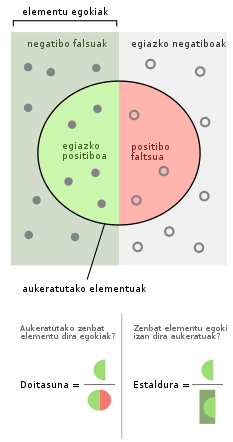

**1.irudia.** *Precision* eta *recall* metriken definizioa eta kalkulatu

Bestalde, F1 ebaluatzen denean bi gauza kontutan hartu behar dira:

1.  Nola definitzen dugu sekuentziako hitz baterako aurreikusitako etiketa, gure ereduak azpi-hitzetarako etiketak baino ez badizkigu ematen? Lehen azpi-hitzerako aurreikusitako etiketa erabiliko dugu hitz osorako etiketa gisa, hitz baten ondorengo azpi-hitzen etiketak alde batera utzita.
 
2.   Nola kalkulatzen dugu entitateen doitasuna eta estaldura? Entitateen kointzidentzia zehatza erabiliko da.  

F1 formula honela kalkulatzen da:   $F1 = 2 \frac{precision * recall}{precision + recall}$




 

In [18]:
def evaluateF1(model, x, y):
    model.eval()
    word_y = []
    word_y_preds = []
    with torch.no_grad():
        for x, y in zip(x, y):
            y_preds=model.forward(x)
            y_preds=torch.argmax(y_preds, dim=2)
            # Convert tags in subword tokens back to word-level sequences, 
            # extracting predicted tag from prediction for first subword of each word
            for i in range(len(y_preds)):
              word_ids = x.word_ids(i)
              curr_y = []
              curr_y_preds = []
              prev_id = -100
              assert len(y_preds[i])==len(y[i]) and len(y_preds[i]) == len(word_ids)
              for id, y_label, y_preds_label in zip(word_ids, y[i], y_preds[i]):
                if id is not None and id!=prev_id:
                  prev_id = id
                  y_label = int(y_label)
                  y_preds_label = int(y_preds_label)
                  curr_y.append(rev_tags[y_label])
                  curr_y_preds.append(rev_tags[y_preds_label])
              word_y.append(curr_y) 
              word_y_preds.append(curr_y_preds)

    # compute precision, recall and F1 on the word level
    precision, recall, F1 = calculateF1(word_y, word_y_preds)
    return precision, recall, F1



def calculateF1(gold_sequences, predicted_sequences):
    
    """ Function to calculate the precision, recall and F-score over labeled chunks in the gold and predicted
    input sequences.  Each input parameter contains a list of label sequences (one label for each word in the
    sentence). In the following example, `gold_sequences` and `predicted_sequences` both contain two sentences
    (the first has 7 words/tags, and the second has 3 words/tags):
    
    gold_sequences=[["B-PER", "I-PER", "O", "O", "O", "O", "B-ORG"], ["O", "O", "O"]]
    predicted_sequences=[["B-PER", "O", "O", "O", "B-PER", "O", "B-ORG"], ["O", "O", "O"]]
    
    Returns tuple of (precision, recall, F1-score)
            for the example precision would be 1/3, recall 1/2, and F1 0.4
    
    """
    assert(len(gold_sequences) == len(predicted_sequences))

    precision, precision_total, recall, recall_total = 0,0,0,0
    for i in range(len(gold_sequences)):
      for j in range(len(gold_sequences[i])):
        if "B-" in gold_sequences[i][j]:
          recall_total += 1

        if "-"  in predicted_sequences[i][j]:
          if "B-" in predicted_sequences[i][j]:
            precision_total += 1
          if gold_sequences[i][j] == predicted_sequences[i][j]:
            if j!= len(gold_sequences[i])-1:
              if "I" not in gold_sequences[i][j+1]:
                precision += 1
                recall += 1
            else:
              precision += 1
              recall += 1
    if precision_total == 0:
      precision = 0
    else:
      precision /= precision_total
    
    if recall_total == 0:
      recall = 0
    else:
      recall /= recall_total

    if precision + recall == 0:
      F1 = 0
    else:
      F1 = (2 * precision * recall)/(precision + recall)
    return precision, recall, F1




### BERT orokorra doitu
Datuak irakurrita, prozesatuta eta mini-batchak eta ebaluazio funtzioak ditugula. Aurre-entrenatutako BERT eredu orokor bat kargatuko da NER etiketatzea egiteko eta traineko datuekin doitu egingo dugu gure probleman hobeto egiten ikasteko. Gero dev-ekin hainbat aldiz konprobatuko da ondo egiten dela eta azkenik, test-ekin ebaluatuko da.

In [19]:
def train_and_evaluate(bert_model_name, model_filename, train_data, dev_data, label_length, embedding_size=768, doLowerCase=None, freezeBert=False, num_epochs=5): # eneko freeze bert

  start_time=time.time()
  bert_model = BERTSequenceLabeler(params={"doLowerCase": doLowerCase, "model_name": bert_model_name, "embedding_size":embedding_size, "label_length": label_length, "freezeBert": freezeBert})
  bert_model.to(device)

  batch_x, batch_y = bert_model.get_batches(train_data)
  dev_batch_x, dev_batch_y = bert_model.get_batches(dev_data)

  optimizer = torch.optim.Adam(bert_model.parameters(), lr=1e-5)
  cross_entropy=nn.CrossEntropyLoss(ignore_index=-1)

  best_dev_acc = 0.

  for epoch in range(num_epochs):
      bert_model.train()

      # Train
      for x, y in tqdm(list(zip(batch_x, batch_y))):
          y_pred = bert_model.forward(x)
          loss = cross_entropy(y_pred.view(-1, bert_model.num_labels), y.view(-1))
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      
      # Evaluate
      bert_model.eval()
      losses = []
      for x,y in tqdm(list(zip(dev_batch_x, dev_batch_y))):
        y_pred = bert_model.forward(x)
        loss = cross_entropy(y_pred.view(-1, bert_model.num_labels), y.view(-1)).item()
        losses.append(loss)
      print('Avg dev loss: %.3f' % torch.mean(torch.tensor(losses)))

      dev_precision, dev_recall, dev_F1=evaluateF1(bert_model, dev_batch_x, dev_batch_y)#F1 erabili
      if epoch % 1 == 0:
          print("Epoch %s, dev accuracy: %.3f,%.3f,%.3f" % (epoch, dev_precision, dev_recall, dev_F1))
          if dev_F1 > best_dev_acc:
              torch.save(bert_model.state_dict(), model_filename)
              best_dev_acc = dev_F1

  print("\nBest Performing Model achieves dev accuracy of :  %.3f,%.3f,%.3f" % (dev_precision, dev_recall, dev_F1))
  print("Time: %.3f seconds ---" % (time.time() - start_time))

Tamaina desberdinetako BERT-ak daude, geruza kopuru desberdinekin (2, 4, 6, 8, 10) eta dimentsio desberdinekin (128, 256, 512). Zenbat eta txikiago izan azkarrago entrenatzen da baina lortzen diren emaitzak txarragoak dira. Beraz, erabaki da ez oso txikia eta ez oso handia den eredu bat erabiltzea. Modu honetan lortzen diren emaitzak nahiko onak izango dira denbora nahiko txikian. Zehazki, *bert-small* erabili da ezkutuko dimentsioa H=512 dena, 4 ezkutuko geruza L=4 eta 8 atentzio geruza A=8 dituena.

Jarraian modelo hori erabili da epoch bakoitzeko *precision*, *recall* eta *F1* lortzen direlarik. F1, aipatu bezala, bi metrikak erlazionatzen dituenez hau erabili hau *best_dev_acc* bezala. 

In [20]:
train_and_evaluate("google/bert_uncased_L-4_H-512_A-8", "ner-bert-small" , trainDataZ1, devDataZ1, max(tag_vocab.values()) + 1, embedding_size=512, doLowerCase=True, num_epochs=50)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/383 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/bert_uncased_L-4_H-512_A-8 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 28/28 [00:01<00:00, 14.31it/s]


Avg dev loss: 0.454
Epoch 0, dev accuracy: 0.700,0.709,0.704


100%|██████████| 28/28 [00:02<00:00, 13.87it/s]


Avg dev loss: 0.387
Epoch 1, dev accuracy: 0.782,0.739,0.760


100%|██████████| 28/28 [00:02<00:00, 13.90it/s]


Avg dev loss: 0.362
Epoch 2, dev accuracy: 0.785,0.760,0.772


100%|██████████| 28/28 [00:02<00:00, 13.63it/s]


Avg dev loss: 0.350
Epoch 3, dev accuracy: 0.792,0.774,0.783


100%|██████████| 28/28 [00:02<00:00, 13.35it/s]


Avg dev loss: 0.342
Epoch 4, dev accuracy: 0.792,0.780,0.786


100%|██████████| 28/28 [00:02<00:00, 13.11it/s]


Avg dev loss: 0.337
Epoch 5, dev accuracy: 0.799,0.783,0.791


100%|██████████| 28/28 [00:02<00:00, 13.14it/s]


Avg dev loss: 0.334
Epoch 6, dev accuracy: 0.801,0.788,0.795


100%|██████████| 28/28 [00:02<00:00, 12.98it/s]


Avg dev loss: 0.330
Epoch 7, dev accuracy: 0.798,0.790,0.794


100%|██████████| 28/28 [00:02<00:00, 13.23it/s]


Avg dev loss: 0.329
Epoch 8, dev accuracy: 0.800,0.790,0.795


100%|██████████| 28/28 [00:02<00:00, 12.99it/s]


Avg dev loss: 0.328
Epoch 9, dev accuracy: 0.804,0.789,0.796


100%|██████████| 28/28 [00:02<00:00, 13.00it/s]


Avg dev loss: 0.327
Epoch 10, dev accuracy: 0.801,0.793,0.797


100%|██████████| 28/28 [00:02<00:00, 13.09it/s]


Avg dev loss: 0.327
Epoch 11, dev accuracy: 0.804,0.792,0.798


100%|██████████| 28/28 [00:02<00:00, 13.01it/s]


Avg dev loss: 0.328
Epoch 12, dev accuracy: 0.811,0.792,0.802


100%|██████████| 28/28 [00:02<00:00, 12.98it/s]


Avg dev loss: 0.328
Epoch 13, dev accuracy: 0.805,0.793,0.799


100%|██████████| 28/28 [00:02<00:00, 12.85it/s]


Avg dev loss: 0.330
Epoch 14, dev accuracy: 0.807,0.792,0.800


100%|██████████| 28/28 [00:02<00:00, 12.84it/s]


Avg dev loss: 0.331
Epoch 15, dev accuracy: 0.808,0.792,0.800


100%|██████████| 28/28 [00:02<00:00, 12.82it/s]


Avg dev loss: 0.332
Epoch 16, dev accuracy: 0.805,0.793,0.799


100%|██████████| 28/28 [00:02<00:00, 12.82it/s]


Avg dev loss: 0.334
Epoch 17, dev accuracy: 0.810,0.792,0.801


100%|██████████| 28/28 [00:02<00:00, 12.86it/s]


Avg dev loss: 0.337
Epoch 18, dev accuracy: 0.807,0.793,0.800


100%|██████████| 28/28 [00:02<00:00, 12.83it/s]


Avg dev loss: 0.340
Epoch 19, dev accuracy: 0.810,0.792,0.801


100%|██████████| 28/28 [00:02<00:00, 12.86it/s]


Avg dev loss: 0.340
Epoch 20, dev accuracy: 0.804,0.792,0.798


100%|██████████| 28/28 [00:02<00:00, 12.84it/s]


Avg dev loss: 0.344
Epoch 21, dev accuracy: 0.805,0.794,0.799


100%|██████████| 28/28 [00:02<00:00, 12.74it/s]


Avg dev loss: 0.347
Epoch 22, dev accuracy: 0.806,0.791,0.798


100%|██████████| 28/28 [00:02<00:00, 12.79it/s]


Avg dev loss: 0.351
Epoch 23, dev accuracy: 0.811,0.794,0.803


100%|██████████| 28/28 [00:02<00:00, 12.83it/s]


Avg dev loss: 0.352
Epoch 24, dev accuracy: 0.801,0.797,0.799


100%|██████████| 28/28 [00:02<00:00, 12.81it/s]


Avg dev loss: 0.353
Epoch 25, dev accuracy: 0.797,0.795,0.796


100%|██████████| 28/28 [00:02<00:00, 12.73it/s]


Avg dev loss: 0.358
Epoch 26, dev accuracy: 0.795,0.798,0.797


100%|██████████| 28/28 [00:02<00:00, 12.80it/s]


Avg dev loss: 0.359
Epoch 27, dev accuracy: 0.781,0.801,0.791


100%|██████████| 28/28 [00:02<00:00, 12.87it/s]


Avg dev loss: 0.363
Epoch 28, dev accuracy: 0.778,0.800,0.789


100%|██████████| 28/28 [00:02<00:00, 12.85it/s]


Avg dev loss: 0.366
Epoch 29, dev accuracy: 0.766,0.799,0.782


100%|██████████| 28/28 [00:02<00:00, 12.73it/s]


Avg dev loss: 0.369
Epoch 30, dev accuracy: 0.776,0.796,0.786


100%|██████████| 28/28 [00:02<00:00, 12.89it/s]


Avg dev loss: 0.374
Epoch 31, dev accuracy: 0.768,0.795,0.782


100%|██████████| 28/28 [00:02<00:00, 12.86it/s]


Avg dev loss: 0.378
Epoch 32, dev accuracy: 0.775,0.794,0.785


100%|██████████| 28/28 [00:02<00:00, 12.86it/s]


Avg dev loss: 0.383
Epoch 33, dev accuracy: 0.794,0.785,0.790


100%|██████████| 28/28 [00:02<00:00, 12.89it/s]


Avg dev loss: 0.387
Epoch 34, dev accuracy: 0.787,0.787,0.787


100%|██████████| 28/28 [00:02<00:00, 12.96it/s]


Avg dev loss: 0.392
Epoch 35, dev accuracy: 0.788,0.788,0.788


100%|██████████| 28/28 [00:02<00:00, 12.87it/s]


Avg dev loss: 0.395
Epoch 36, dev accuracy: 0.782,0.789,0.785


100%|██████████| 28/28 [00:02<00:00, 12.73it/s]


Avg dev loss: 0.399
Epoch 37, dev accuracy: 0.782,0.790,0.786


100%|██████████| 28/28 [00:02<00:00, 12.74it/s]


Avg dev loss: 0.401
Epoch 38, dev accuracy: 0.798,0.781,0.789


100%|██████████| 28/28 [00:02<00:00, 12.76it/s]


Avg dev loss: 0.407
Epoch 39, dev accuracy: 0.788,0.793,0.791


100%|██████████| 28/28 [00:02<00:00, 12.83it/s]


Avg dev loss: 0.413
Epoch 40, dev accuracy: 0.805,0.783,0.794


100%|██████████| 28/28 [00:02<00:00, 12.85it/s]


Avg dev loss: 0.418
Epoch 41, dev accuracy: 0.812,0.776,0.793


100%|██████████| 28/28 [00:02<00:00, 12.85it/s]


Avg dev loss: 0.422
Epoch 42, dev accuracy: 0.812,0.777,0.794


100%|██████████| 28/28 [00:02<00:00, 12.87it/s]


Avg dev loss: 0.420
Epoch 43, dev accuracy: 0.796,0.783,0.789


100%|██████████| 28/28 [00:02<00:00, 12.82it/s]


Avg dev loss: 0.430
Epoch 44, dev accuracy: 0.813,0.774,0.793


100%|██████████| 28/28 [00:02<00:00, 12.80it/s]


Avg dev loss: 0.433
Epoch 45, dev accuracy: 0.813,0.779,0.796


100%|██████████| 28/28 [00:02<00:00, 12.87it/s]


Avg dev loss: 0.439
Epoch 46, dev accuracy: 0.818,0.773,0.795


100%|██████████| 28/28 [00:02<00:00, 12.80it/s]


Avg dev loss: 0.447
Epoch 47, dev accuracy: 0.828,0.771,0.799


100%|██████████| 28/28 [00:02<00:00, 12.77it/s]


Avg dev loss: 0.462
Epoch 48, dev accuracy: 0.843,0.766,0.803


100%|██████████| 28/28 [00:02<00:00, 12.82it/s]


Avg dev loss: 0.468
Epoch 49, dev accuracy: 0.849,0.766,0.805

Best Performing Model achieves dev accuracy of :  0.849,0.766,0.805
Time: 1364.229 seconds ---


Azkenik, test-ean probatuko dugu gure modelo hoberena. Horretarako:  


1.   Aurre-entrenatutako modeloa hasieratuko dugu aurretik egin dugun moduan.
2.   Parametroak berridatziko ditugu gordetako modeloa erabiliz,
3. Gure modeloa ebaluatuko dugu test-eko datuak hartuz. Metrikak *precision*, *recall* eta *F1* dira hurrenez hurren.


In [25]:
bert=BERTSequenceLabeler(params={"doLowerCase": True, "model_name": "google/bert_uncased_L-4_H-512_A-8", "embedding_size":512, "label_length": max(tag_vocab.values())+1})
bert.to(device)
bert.load_state_dict(torch.load('ner-bert-small'))

test_batch_x, test_batch_y = bert.get_batches(testDataZ1)
test_precision, test_recall, test_F1 = evaluateF1(bert, test_batch_x, test_batch_y)
print("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (test_precision, test_recall, test_F1))

'''
train_batch_x, train_batch_y = bert.get_batches(trainDataZ1)
train_precision, train_recall, train_F1 = evaluateF1(bert, train_batch_x, train_batch_y)
print("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (train_precision, train_recall, train_F1))

dev_batch_x, dev_batch_y = bert.get_batches(devDataZ1)
dev_precision, dev_recall, dev_F1 = evaluateF1(bert, dev_batch_x, dev_batch_y)
print("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (dev_precision, dev_recall, dev_F1))
'''

Some weights of the model checkpoint at google/bert_uncased_L-4_H-512_A-8 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Best Performing Model achieves test accuracy of :  0.848,0.766,0.805


'\ntrain_batch_x, train_batch_y = bert.get_batches(trainDataZ1)\ntrain_precision, train_recall, train_F1 = evaluateF1(bert, train_batch_x, train_batch_y)\nprint("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (train_precision, train_recall, train_F1))\n\ndev_batch_x, dev_batch_y = bert.get_batches(devDataZ1)\ndev_precision, dev_recall, dev_F1 = evaluateF1(bert, dev_batch_x, dev_batch_y)\nprint("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (dev_precision, dev_recall, dev_F1))\n'

### Pub


In [ ]:
train_and_evaluate("dmis-lab/biobert-base-cased-v1.1", "ner-biobert" , trainDataZ1, devDataZ1, max(tag_vocab.values()) + 1, embedding_size=512, doLowerCase=True, num_epochs=50)

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

  0%|          | 0/83 [00:00<?, ?it/s]

## Z2
Hizkuntza-eredu bat doitu (fine-tuning) MedMentions-eko
corpusarekin NER egiteko.  
Sistemari hobekuntzak egitea hobesten da. Aurrekoan bezala, sistema test multzoaren kontra ebaluatu egin behar da eta ebaluazio-metrikak eman beharko dira taula batean.  
Klase bakarrekin lan egiteaz gain, Medmentions-eko klase semantiko ezberdinak
bereiziko dira. Ez dira klase guztiak detektatuko, detekzio finago egingo da. Zehazki, detektatuko dira gaixotasunekin erlazio duten klaseak:  

|Klase mota|Klasearen IDa|
|--|--|
Health Care Activity | T058
Laboratory Procedure | T059
Diagnostic Procedure | T060
Therapeutic or Preventive Procedure | T061
Disease or Syndrome | T047
Mental or Behavioral Dysfunction | T048
Neoplastic Process | T191
Experimental Model of Disease | T050
Organism | T001
Virus | T005
Bacterium | T007
Anatomical Structure | T017
Embryonic Structure | T018
Fully Formed Anatomical Structure | T021
Body Part, Organ, or Organ Component | T023
Anatomical Abnormality | T190
Congenital Abnormality | T019
Acquired Abnormality | T020
Clinical Drug | T200
Pharmacologic Substance | T121
Antibiotic | T195
Finding | T033
Sign or Symptom | T184

Horretarako, lehenik hiztegi bat definituko dugu klasearen IDa eta klase mota daukagula bakoitzeko.

In [30]:
#klaseak
klaseak = ["Health Care Activity", "Laboratory Procedure", "Diagnostic Procedure", "Therapeutic or Preventive Procedure", "Disease or Syndrome", "Mental or Behavioral Dysfunction", "Neoplastic Process", 
           "Experimental Model of Disease", "Organism", "Virus", " Bacterium" , "Anatomical Structure", "Embryonic Structure", "Fully Formed Anatomical Structure", "Body Part, Organ, or Organ Component",
           "Anatomical Abnormality", "Congenital Abnormality", "Acquired Abnormality", "Clinical Drug", "Pharmacologic Substance", "Antibiotic", "Finding", "Sign or Symptom"]

klaseak_ID = ["T058", "T059", "T060", "T061", "T047", "T048", "T191", "T050", "T001", "T005", "T007", "T017", "T018", "T021", "T023", "T190", "T019", "T020", "T200", "T121", "T195", "T033", "T184"]

etiketak = {}

assert(len(klaseak) == len(klaseak_ID))

for i in range(len(klaseak_ID)):
  etiketak[klaseak_ID[i]] = klaseak[i]

Konprobatu ondo sortuta dago datu-egitura:

In [31]:
print(etiketak)

{'T058': 'Health Care Activity', 'T059': 'Laboratory Procedure', 'T060': 'Diagnostic Procedure', 'T061': 'Therapeutic or Preventive Procedure', 'T047': 'Disease or Syndrome', 'T048': 'Mental or Behavioral Dysfunction', 'T191': 'Neoplastic Process', 'T050': 'Experimental Model of Disease', 'T001': 'Organism', 'T005': 'Virus', 'T007': ' Bacterium', 'T017': 'Anatomical Structure', 'T018': 'Embryonic Structure', 'T021': 'Fully Formed Anatomical Structure', 'T023': 'Body Part, Organ, or Organ Component', 'T190': 'Anatomical Abnormality', 'T019': 'Congenital Abnormality', 'T020': 'Acquired Abnormality', 'T200': 'Clinical Drug', 'T121': 'Pharmacologic Substance', 'T195': 'Antibiotic', 'T033': 'Finding', 'T184': 'Sign or Symptom'}


### BIO etiketatzea
Orain datuak BIO etiketatzera pasatuko ditugu. Kasu honetan, Z1en ez bezala, etiketa anitz izango ditugu. Etiketa hauek aurretIk definitu dira eta zehazki gaixotasunekin erlazio duten etiketak bakarrik dira. Beraz, tokena entitate baten hasiera baldin bada B-klasearenID etiketa jasoko du. I-klasearenID izango du aldiz, entitatearen barruan baldin badago eta 0 ez bada entitate bat edota entitate horren ID aurretik definitukoen artean ez badago. Jarraian adibide bat aurkezten da. Kasu horretan DCTN4 entitate bat da baina honen klaseen IDak T116, T123 dira eta hauek ez daudenez definitu ditugun etiketen artean, O etiketa hartzen du:

```
[DCTN4] as a modifier of [chronic Pseudomonas aeruginosa infection] in [cystic fibrosis]

O O O O O B-T047 I-T047 I-T047 I-T047 O B-T047 I-T047
```

Lehenik eta behin fitxategi berriak sortuko dira *train*, *dev* eta *test* partizio bakoitzeko kasuak BIO etiketatzean gordetzeko.

In [32]:
#Aldagai orokorrak
train_BIO_directory_Z2 = "corpus_BIO_train_Z2.txt"
dev_BIO_directory_Z2 = "corpus_BIO_dev_Z2.txt"
test_BIO_directory_Z2 = "corpus_BIO_test_Z2.txt"

#sortu fitxategiak
createFile("./" + train_BIO_directory_Z2)
createFile("./" + dev_BIO_directory_Z2)
createFile("./" + test_BIO_directory_Z2)

Hurrengo funtzioak fitxategi bakoitza irakurri eta BIO moduan etiketatzen ditu klase anitz ditugula. 

In [33]:
def readBIO_Z2_txt(filename, write_directory):
    
    """ Read input one by line """
    with open(filename) as file:
        lines = "" #it  will contain the tittle and abstract
        entitate_guztiak = []
        cont = 0
        cont_len = 0
        for line in file:
          if  "|" in line:
            if cont % 2 == 0 and cont != 0:
              #idatzi
              idatzi_entitateak(entitate_guztiak, write_directory)
              entitate_guztiak = []
              lines = ""           
              cont_len = 0   
            cont += 1
            text_ta = (line.split("|")[2]).split("\n")[0]
            tokenizatu_text_ta = tokenize(text_ta+ " ")
            for t in tokenizatu_text_ta:
              entitate_guztiak.append([t,cont_len , cont_len+len(t) ,"O"])
              cont_len += len(t)
            lines += text_ta + " "
          else:
            desk = line.split("\t")
            index_start = int(desk[1])
            index_end = int(desk[2])
            klase_id_ = str(desk[4]).split(",")
            klase_id = []
            #ikusiko dugu ea id-ren bat etiketen artean dagoen
            for id in klase_id_:
              if id  in etiketak.keys(): # badago
                klase_id.append(id)
            entitate = lines[index_start:index_end]
            entitate_tokenizatu = tokenize(entitate)
            first = True
            if len(klase_id) > 0:
              for ent in entitate_tokenizatu:
                if first:
                  if ent != " " :
                    try:
                      index = entitate_guztiak.index([ent,index_start, index_start + len(ent), "O"])
                      entitate_guztiak[index] = [ent,index_start, index_start + len(ent), "B-"+",".join(klase_id)]
                      index_start += len(ent)
                      first = False
                    except:
                      index += 1
                      entitate_guztiak.insert(index, [ent, len(entitate_guztiak[index-1][0]), len(entitate_guztiak[index-1][0])+len(ent), "B-"+",".join(klase_id)])
                      index_start += len(ent)
                      first = False
                  else:
                    index_start += 1
                elif ent != " ":
                  try:
                    index = entitate_guztiak.index([ent,index_start, index_start +len(ent), "O"])
                    entitate_guztiak[index] = [ent,index_start, index_start +len(ent), "I-"+",".join(klase_id)]
                    index_start += len(ent)
                  except:
                    index += 1
                    entitate_guztiak.insert(index, [ent, len(entitate_guztiak[index-1][0]), len(entitate_guztiak[index-1][0])+len(ent), "I-"+",".join(klase_id)])
                    index_start += len(ent)
                else:
                  index_start += 1
        #azkena
        idatzi_entitateak(entitate_guztiak, write_directory)

In [ ]:
readBIO_Z2_txt(dev_def_directory ,dev_BIO_directory_Z2)
readBIO_Z2_txt(test_def_directory ,test_BIO_directory_Z2)
readBIO_Z2_txt(train_def_directory ,train_BIO_directory_Z2)

### BIO moduan etiketatutako datuak irakurri

Aurretik definitutako ```read_txt()``` funtzioa erabiliko da aurretik etiketatu diren datuak irakurtzeko. Funtzio horrek datuak irakurri eta esaldiz osatutako lista bat sortzen du. Esaldi bakoitza tuplas osatutako lista bat da eta tupla bakoitzA bi elementuz osatuta dago: hitza eta etiketa (O,B,I).


In [34]:
trainDataZ2 = read_txt(train_BIO_directory_Z2)
devDataZ2 = read_txt(dev_BIO_directory_Z2)
testDataZ2 = read_txt(test_BIO_directory_Z2)

Ikusiko da egitura egokia dela, hau da, aurretik aipatuta egitura duela:

In [35]:
print(trainDataZ2[0])
print(len(trainDataZ2))
print(len(devDataZ2))
print(len(testDataZ2))

[('An', 'O'), ('S116R', 'O'), ('Phosphorylation', 'O'), ('Site', 'O'), ('Mutation', 'O'), ('in', 'O'), ('Human', 'O'), ('Fibroblast', 'O'), ('Growth', 'O'), ('Factor-1', 'O'), ('Differentially', 'O'), ('Affects', 'O'), ('Mitogenic', 'O'), ('and', 'O'), ('Glucose', 'B-T033'), ('-', 'I-T033'), ('Lowering', 'I-T033'), ('Activities', 'I-T033'), ('Fibroblast', 'O'), ('growth', 'O'), ('factor-1', 'O'), ('(', 'O'), ('FGF-1', 'O'), (')', 'O'), (',', 'O'), ('a', 'O'), ('potent', 'O'), ('human', 'O'), ('mitogen', 'O'), ('and', 'O'), ('insulin', 'B-T121'), ('sensitizer', 'O'), (',', 'O'), ('signals', 'O'), ('through', 'O'), ('both', 'O'), ('tyrosine', 'O'), ('kinase', 'O'), ('receptor', 'O'), ('-mediated', 'O'), ('autocrine', 'O'), ('/', 'O'), ('paracrine', 'O'), ('pathways', 'O'), ('as', 'O'), ('well', 'O'), ('as', 'O'), ('a', 'O'), ('nuclear', 'O'), ('intracrine', 'O'), ('pathway', 'O'), ('.', 'O'), ('Phosphorylation', 'O'), ('of', 'O'), ('FGF-1', 'O'), ('at', 'O'), ('serine', 'B-T121'), ('116'

Orain, entrenamendu-datuetan jaso ahal diren etiketa guztien indize bat eman zaie, hurrengo datu-egitura sortuz: hiztegi bat etiketekin eta indizearekin, eta alderantzizko hiztegia indezeekin eta etiketekin. Horretako aurretik definitutako ```get_tag_vocab()```funtzioa erabiliko da. Gero, inprimatzen dira sortutako bi egitura berriak. Kasu honetan, Z1n ez bezala, 3 etiketa baino gehiago izango ditugu ez daukagulako etiketa bakarra.


In [36]:
tag_vocab,rev_tags=get_tag_vocab(trainDataZ2)

print(tag_vocab)
print(rev_tags)
print(rev_tags[0])

{'O': 0, 'B-T033': 1, 'I-T033': 2, 'B-T121': 3, 'I-T121': 4, 'B-T047': 5, 'I-T047': 6, 'B-T061': 7, 'B-T059': 8, 'I-T059': 9, 'I-T061': 10, 'B-T058': 11, 'I-T058': 12, 'B-T184': 13, 'I-T184': 14, 'B-T060': 15, 'I-T060': 16, 'B-T005': 17, 'B-T007': 18, 'B-T001': 19, 'I-T007': 20, 'B-T191': 21, 'B-T023': 22, 'I-T023': 23, 'B-T019': 24, 'I-T019': 25, 'B-T050': 26, 'I-T050': 27, 'I-T001': 28, 'B-T048': 29, 'B-T020': 30, 'I-T191': 31, 'B-T190': 32, 'I-T190': 33, 'I-T048': 34, 'B-T195': 35, 'I-T005': 36, 'I-T195': 37, 'B-T017': 38, 'I-T020': 39, 'B-T200': 40, 'I-T200': 41, 'B-T018': 42, 'I-T017': 43, 'I-T018': 44, 'B-T019,T047': 45, 'I-T019,T047': 46, 'B-T047,T190': 47, 'I-T047,T190': 48, 'B-T021': 49}
{0: 'O', 1: 'B-T033', 2: 'I-T033', 3: 'B-T121', 4: 'I-T121', 5: 'B-T047', 6: 'I-T047', 7: 'B-T061', 8: 'B-T059', 9: 'I-T059', 10: 'I-T061', 11: 'B-T058', 12: 'I-T058', 13: 'B-T184', 14: 'I-T184', 15: 'B-T060', 16: 'I-T060', 17: 'B-T005', 18: 'B-T007', 19: 'B-T001', 20: 'I-T007', 21: 'B-T191', 

### BERT orokorra doitu

Datuak irakurrita, prozesatuta eta mini-batchak eta ebaluazio funtzioak ditugula (hauek Z1en definitu dira). Aurre-entrenatutako BERT eredu orokor bat kargatuko da NER etiketatzea egiteko eta traineko datuekin doitu egingo dugu gure probleman hobeto egiten ikasteko. Gero dev-ekin hainbat aldiz konprobatuko da ondo egiten dela eta azkenik, test-ekin ebaluatuko da.

Tamaina desberdinetako BERT-ak daude, geruza kopuru desberdinekin (2, 4, 6, 8, 10) eta dimentsio desberdinekin (128, 256, 512). Zenbat eta txikiago izan azkarrago entrenatzen da baina lortzen diren emaitzak txarragoak dira. Beraz, erabaki da ez oso txikia eta ez oso handia den eredu bat erabiltzea. Modu honetan lortzen diren emaitzak nahiko onak izango dira denbora nahiko txikian. Zehazki, *bert-small* erabili da ezkutuko dimentsioa H=512 dena, 4 ezkutuko geruza L=4 eta 8 atentzio geruza A=8 dituena.

Jarraian modelo hori erabili da epoch bakoitzeko *precision*, *recall* eta *F1* lortzen direlarik. F1, aipatu bezala, bi metrikak erlazionatzen dituenez hau erabili hau *best_dev_acc* bezala. 

In [38]:
train_and_evaluate("google/bert_uncased_L-4_H-512_A-8", "ner-bert-small-Z2" , trainDataZ2, devDataZ2, max(tag_vocab.values()) + 1, embedding_size=512, doLowerCase=True, num_epochs=50)

Some weights of the model checkpoint at google/bert_uncased_L-4_H-512_A-8 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


KeyError: ignored

Azkenik, test-ean probatuko dugu gure modelo hoberena. Horretarako:  


1.   Aurre-entrenatutako modeloa hasieratuko dugu aurretik egin dugun moduan.
2.   Parametroak berridatziko ditugu gordetako modeloa erabiliz,
3. Gure modeloa ebaluatuko dugu test-eko datuak hartuz. Metrikak *precision*, *recall* eta *F1* dira hurrenez hurren.


In [ ]:
bert=BERTSequenceLabeler(params={"doLowerCase": True, "model_name": "google/bert_uncased_L-4_H-512_A-8", "embedding_size":512, "label_length": max(tag_vocab.values())+1})
bert.to(device)
bert.load_state_dict(torch.load('ner-bert-small-Z2'))

test_batch_x, test_batch_y = bert.get_batches(testDataZ2)
test_precision, test_recall, test_F1 = evaluateF1(bert, test_batch_x, test_batch_y)
print("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (test_precision, test_recall, test_F1))

'''
train_batch_x, train_batch_y = bert.get_batches(trainDataZ1)
train_precision, train_recall, train_F1 = evaluateF1(bert, train_batch_x, train_batch_y)
print("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (train_precision, train_recall, train_F1))

dev_batch_x, dev_batch_y = bert.get_batches(devDataZ1)
dev_precision, dev_recall, dev_F1 = evaluateF1(bert, dev_batch_x, dev_batch_y)
print("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (dev_precision, dev_recall, dev_F1))
'''

Some weights of the model checkpoint at google/bert_uncased_L-4_H-512_A-8 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Best Performing Model achieves test accuracy of :  0.848,0.766,0.805


'\ntrain_batch_x, train_batch_y = bert.get_batches(trainDataZ1)\ntrain_precision, train_recall, train_F1 = evaluateF1(bert, train_batch_x, train_batch_y)\nprint("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (train_precision, train_recall, train_F1))\n\ndev_batch_x, dev_batch_y = bert.get_batches(devDataZ1)\ndev_precision, dev_recall, dev_F1 = evaluateF1(bert, dev_batch_x, dev_batch_y)\nprint("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (dev_precision, dev_recall, dev_F1))\n'

# TRASH

In [ ]:

            '''
            desk = line.split("\t")
            index_start = int(desk[1])
            index_end = int(desk[2])
            text_segment = desk[3].split(" ")
            first = True
            #print(cont)
            while cont != index_end:
              if cont < index_start:
                fragment = lines[cont:index_start]
                print(fragment)
                tokens = fragment.split(" ")
                for token in tokens:
                  if token !=" ":
                    text = token+"\t O \n"
                    idatzi_kasua(write_directory, text)
                cont += len(fragment)
                print(cont)
              elif cont == index_start:
                print("sartu")
                if len(text_segment) == 1: #hitz bakarrez osatuta
                  text = lines[cont:index_end+1] +"\t B-MED \n"
                  idatzi_kasua(write_directory, text)
                else: 
                  for segment in text_segment:
                    if first:
                      text = lines[cont:cont+len(segment)] +"\t B-MED \n"
                      idatzi_kasua(write_directory, text)
                      first = False
                      cont = len(text)+1
                    else:
                      text = lines[cont:cont+len(segment)] +"\t I-MED \n"
                      idatzi_kasua(write_directory, text)
                cont = index_end
              lines = lines[index_end:]
            
            sartu = False
            print(lines)
            desk = line.split("\t")
            index_start = int(desk[1])
            index_end = int(desk[2])
            del  lines[0:len(remove_list)]
            remove_list = []
            for l in lines:
              print(cont)
              if cont == index_end:
                print("sartu")
                break
              if l == " ":
                cont += 1
                remove_list.append(lines.index(l))
              elif cont == index_start:
                text = l +"\t B-MED \n"
                sartu = True
                idatzi_kasua(write_directory, text)
                remove_list.append(lines.index(l))
              elif cont < index_end and sartu:
                sartu = False
                cont += len(l)
                text = l +"\t I-MED \n"
                idatzi_kasua(write_directory, text)
                remove_list.append(lines.index(l))
              else:
                cont += len(l) 
                text = l +"\t O \n"
                idatzi_kasua(write_directory, text)
                remove_list.append(lines.index(l))








        atera = False
            while not atera:
              if cont == index_start or cont > index_start:
                if len(text_segment) == 1: #entity has only one word
                  if cont > index_start:
                    cont = index_start
                  l = lines[cont:index_end]
                  cont += len(l)
                  text = l +"\t B-MED \n"
                  idatzi_kasua(write_directory, text)
                  atera = True
                elif len(text_segment) > 1 : #entity has more than one word 
                  count = 0
                  if cont > index_start:
                      cont = index_start
                  while cont != index_end:
                    if cont == index_start:
                      l = lines[cont:len(text_segment[0])]
                      text =  l +"\t B-MED \n"
                      idatzi_kasua(write_directory, text)
                    else:
                      l = lines[cont:len(text_segment[count])]
                      text = l +"\t I-MED \n"
                      idatzi_kasua(write_directory, text)
                    count += 1
                    cont += len(l)
                  atera = True

              else:
                text_other_segment = tokenize(lines[cont:index_start])
                count = 0
                for l in text_other_segment:
                  if l != " ":
                    text = l +"\t O \n"
                    idatzi_kasua(write_directory, text)
                    count += 1
              
                  cont += len(l)

                '''
              
            
           

'\ndesk = line.split("\t")\nindex_start = int(desk[1])\nindex_end = int(desk[2])\ntext_segment = desk[3].split(" ")\nfirst = True\n#print(cont)\nwhile cont != index_end:\n  if cont < index_start:\n    fragment = lines[cont:index_start]\n    print(fragment)\n    tokens = fragment.split(" ")\n    for token in tokens:\n      if token !=" ":\n        text = token+"\t O \n"\n        idatzi_kasua(write_directory, text)\n    cont += len(fragment)\n    print(cont)\n  elif cont == index_start:\n    print("sartu")\n    if len(text_segment) == 1: #hitz bakarrez osatuta\n      text = lines[cont:index_end+1] +"\t B-MED \n"\n      idatzi_kasua(write_directory, text)\n    else: \n      for segment in text_segment:\n        if first:\n          text = lines[cont:cont+len(segment)] +"\t B-MED \n"\n          idatzi_kasua(write_directory, text)\n          first = False\n          cont = len(text)+1\n        else:\n          text = lines[cont:cont+len(segment)] +"\t I-MED \n"\n          idatzi_kasua(write

In [ ]:
def readBIO2_txt(filename, write_directory):
    
    """ Read input one by line """
    with open(filename) as file:
        lines = [] #it  will contain the tittle and abstract
        cont = 0
        remove_list = []
        prev_index_start = None
        prev_index_end = -1
        sartu  = False
        for line in file:
          if  "|" in line:
            text_ta = (line.split("|")[2]).split("\n")[0]
            lines.extend(tokenize(text_ta))
          else:
            print(lines)
            desk = line.split("\t")
            index_start = int(desk[1])
            index_end = int(desk[2])
            prev = False
            if prev_index_start == index_start:
              del  lines[0:len(remove_list)-len(text_segment)]
            elif  index_start < prev_index_end:
              prev = True
              del lines[0:len(remove_list)-len(text_segment)]
            else:
              del  lines[0:len(remove_list)]
            prev_index_start = index_start
            prev_index_end = index_end
            text_segment = tokenize(desk[3])
            remove_list = []
            for l in lines:
              if l in text_segment: #if it is in MentionTextSegment
                cont += 1
                if len(text_segment) == 1 and text_segment[0] == l: #entity has only one word
                  text = "  ".join(text_segment) + " " +l +"\t B-MED \n"
                  idatzi_kasua(write_directory, text)
                elif len(text_segment) > 1 and text_segment[0] == l: #entity has more than one word and l is the fist one
                  sartu = True
                  text = "  ".join(text_segment)+ " "  + l +"\t B-MED \n"
                  idatzi_kasua(write_directory, text)
                elif  len(text_segment) > 1 and text_segment[0] != l and sartu: #entity has more than one word and l is not the fist one
                  text = "  ".join(text_segment)+ " "  + l +"\t I-MED \n"
                  idatzi_kasua(write_directory, text)
                remove_list.append(lines.index(l))

                if cont == len(text_segment):
                  sartu = False
                  cont = 0
                  break

              elif  not prev: #if it is NOT  in MentionTextSegment
                text =   "  ".join(text_segment)+ " "  + l +"\t O \n"
                idatzi_kasua(write_directory, text)
                remove_list.append(lines.index(l))

            